In [94]:
import os
import glob
import pandas as pd

# The base directory where ISR folders are located
base_dir = './'

# List of folders to check for data (as per the user's file structure)
isr_folders = [f for f in os.listdir(base_dir) if f.startswith('ISR')]
print(len(isr_folders))

# Prepare to read the CSV files from CP1 to CP8 in each ISR folder
cp_files = [f'CP{cp_num}' for cp_num in range(1, 9)]  # CP1 to CP8
csv_data = {}  # A dictionary to hold the dataframes

# Initialize counters
folders_read = 0
files_read = 0

41


In [95]:
# Loop through each ISR folder and each CP file
for isr_folder in isr_folders:
    folders_read += 1
    isr_path = os.path.join(base_dir, isr_folder, 'Simulator outputs', 'csv')
    found_files_in_folder = False

    for cp_file in cp_files:
        # Construct file pattern
        file_pattern = f'CSVScenario-{cp_file}_Session*.csv'
        file_path_pattern = os.path.join(isr_path, file_pattern)
        
        # Find all files matching the pattern
        matching_files = glob.glob(file_path_pattern)
        for file_path in matching_files:
            found_files_in_folder = True
            files_read += 1

            # Read the CSV file
            csv_data[f'{isr_folder}_{cp_file}'] = pd.read_csv(file_path, delimiter=';')

# Print out the results
print(f'{folders_read} ISR folders were identified.')
print(f'{files_read} CSV files were found.')

# Display the content of one of the files as an example
# We'll display the first file from the dictionary
example_key = next(iter(csv_data))
csv_data[example_key].head()  # Show the first few rows of the example dataframe
print(csv_data[example_key].head())

41 ISR folders were identified.
274 CSV files were found.
   AccelA  AccelB  ButtonA  ButtonB  Car PositionXA  Car PositionXB   
0  0.0002     0.0    False    False         80.8691         80.8691  \
1  0.0001     0.0    False    False         80.8692         80.8692   
2  0.0001     0.0    False    False         80.8692         80.8692   
3  0.0000     0.0    False    False         80.8693         80.8693   
4  0.0000     0.0    False    False         80.8692         80.8692   

   Car PositionYA  Car PositionYB  Car PositionZA  Car PositionZB  ...   
0         -0.0169         -0.0169        -75.1498        -75.1498  ...  \
1         -0.0110         -0.0110        -75.1500        -75.1500  ...   
2         -0.0072         -0.0072        -75.1501        -75.1501  ...   
3         -0.0049         -0.0049        -75.1502        -75.1502  ...   
4         -0.0036         -0.0036        -75.1503        -75.1503  ...   

   HeadrotZB           IndicatorsA           IndicatorsB   
0   358.34

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Concatenate all the dataframes
all_data = pd.concat(csv_data.values())

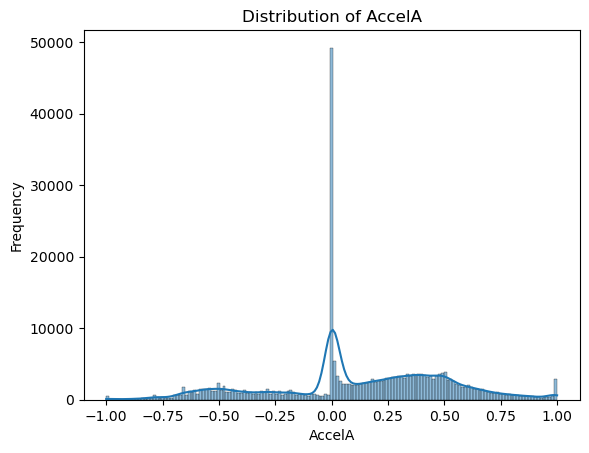

In [98]:
# Visualization 1: Distribution of AccelA
sns.histplot(all_data['AccelA'], kde=True)
plt.title('Distribution of AccelA')
plt.xlabel('AccelA')
plt.ylabel('Frequency')
plt.show()

In [99]:
# Replace all NaNs with 0.0001
all_data.fillna(0.0001, inplace=True)

# Convert boolean to int (True to 1, False to 0)
bool_columns = all_data.select_dtypes(include=['bool']).columns
all_data[bool_columns] = all_data[bool_columns].astype(int)

# Retain only numeric columns (including those converted from boolean)
all_data_numeric = all_data.select_dtypes(include=[np.number])

# Display the first few rows of the processed dataframe
print(all_data_numeric)

      AccelA  AccelB  ButtonA  ButtonB  Frame Number  FrameRate  GameTime   
0     0.0002  0.0000        0        0         18309   71.52988    153.24  \
1     0.0001  0.0000        0        0         18313   64.09889    153.31   
2     0.0001  0.0000        0        0         18318   66.36057    153.39   
3     0.0000  0.0000        0        0         18323   69.76397    153.46   
4     0.0000  0.0000        0        0         18328   71.07462    153.53   
...      ...     ...      ...      ...           ...        ...       ...   
1221 -0.5625  0.0000        0        0        447577   71.72406   4731.72   
1222 -0.5547  0.0000        0        0        447582   71.78844   4731.79   
1223 -0.5508  0.0000        0        0        447587   71.92785   4731.86   
1224 -0.5430  0.0000        0        0        447592   71.97544   4731.93   
1225 -0.5195 -0.0317        0        0        447597   47.23551   4732.04   

      HeadPosXA  HeadPosXB  HeadPosYA  ...  HeadPosZB  HeadrotXA  HeadrotXB

In [100]:
# Filter the data based on the specified conditions
filtered_data = all_data_numeric[
    (all_data_numeric['HeadPosXA'].abs() <= 35) &
    (all_data_numeric['HeadPosXB'].abs() <= 35) &
    (all_data_numeric['HeadPosYA'].abs() <= 35) &
    (all_data_numeric['HeadPosYB'].abs() <= 35)
]

print("Number of rows after filtering:", filtered_data.shape[0])

Number of rows after filtering: 135495


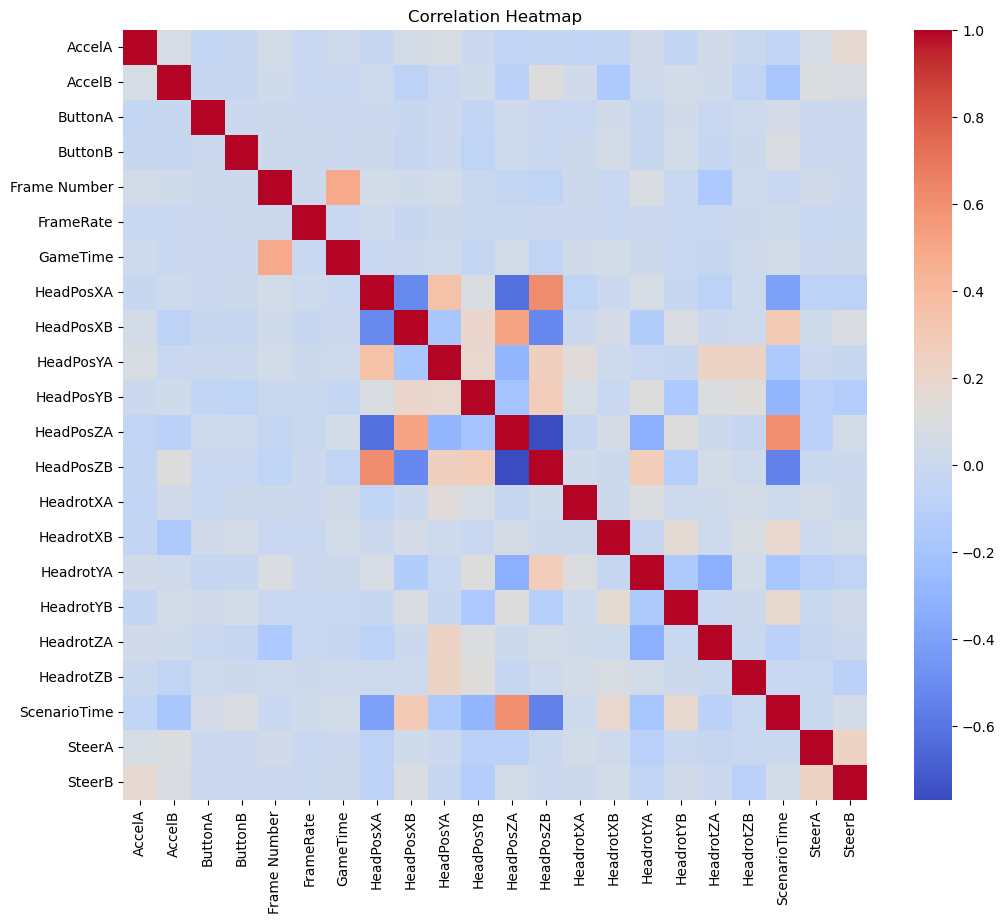

In [101]:
# Visualization 2: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_data.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

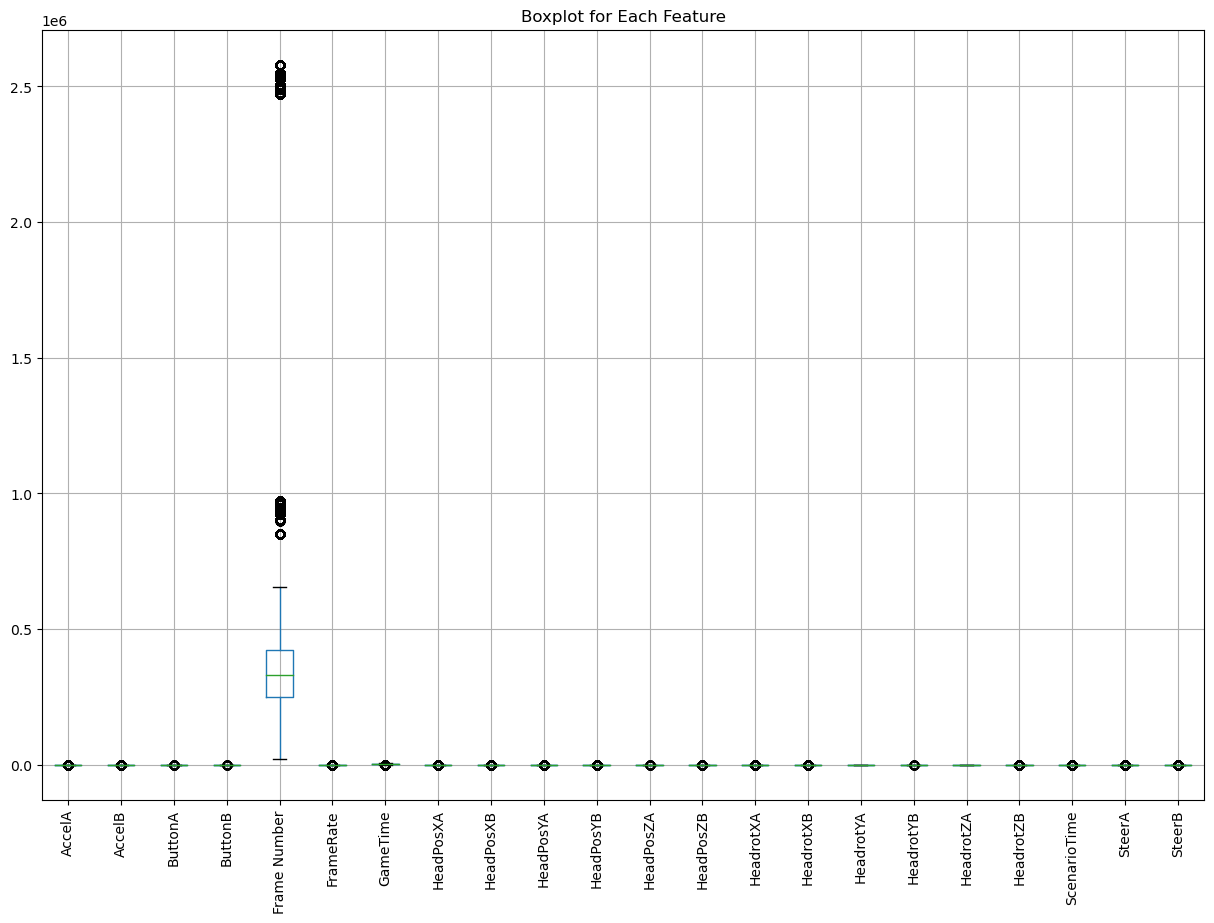

In [103]:
# Visualization 3: Boxplot for Each Feature
plt.figure(figsize=(15, 10))
filtered_data.boxplot()
plt.title('Boxplot for Each Feature')
plt.xticks(rotation=90)
plt.show()

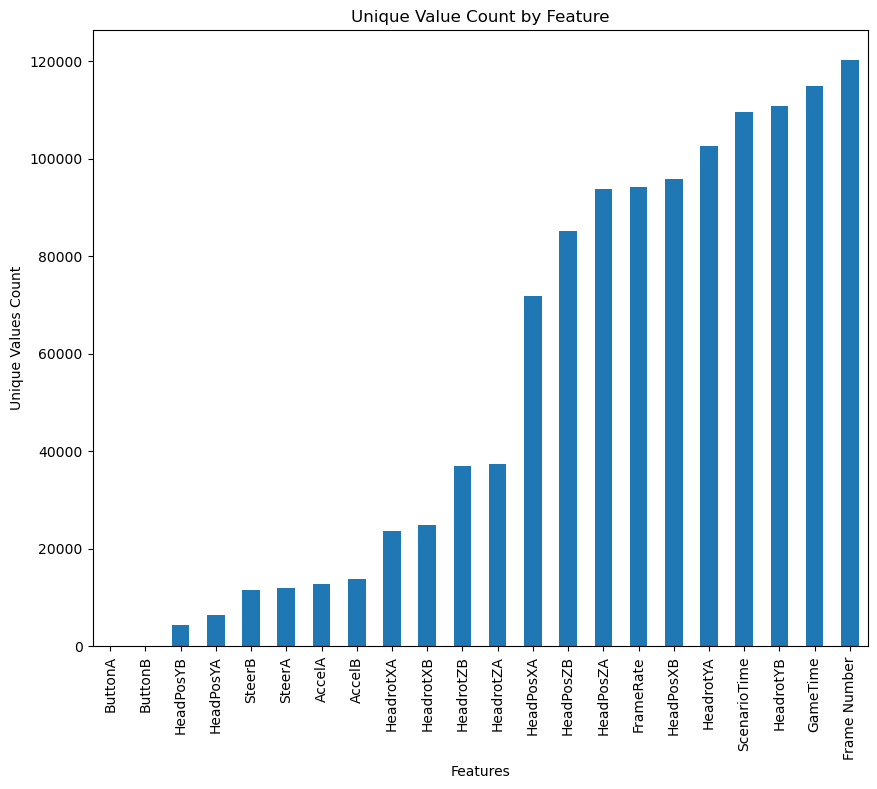

In [104]:
# Visualization 4: Count of Unique Values per Feature
# Purpose: To identify categorical features with a high cardinality or features with constant or near-constant values.
unique_counts = filtered_data.nunique().sort_values()
plt.figure(figsize=(10, 8))
unique_counts.plot(kind='bar')
plt.title('Unique Value Count by Feature')
plt.xlabel('Features')
plt.ylabel('Unique Values Count')
plt.show()

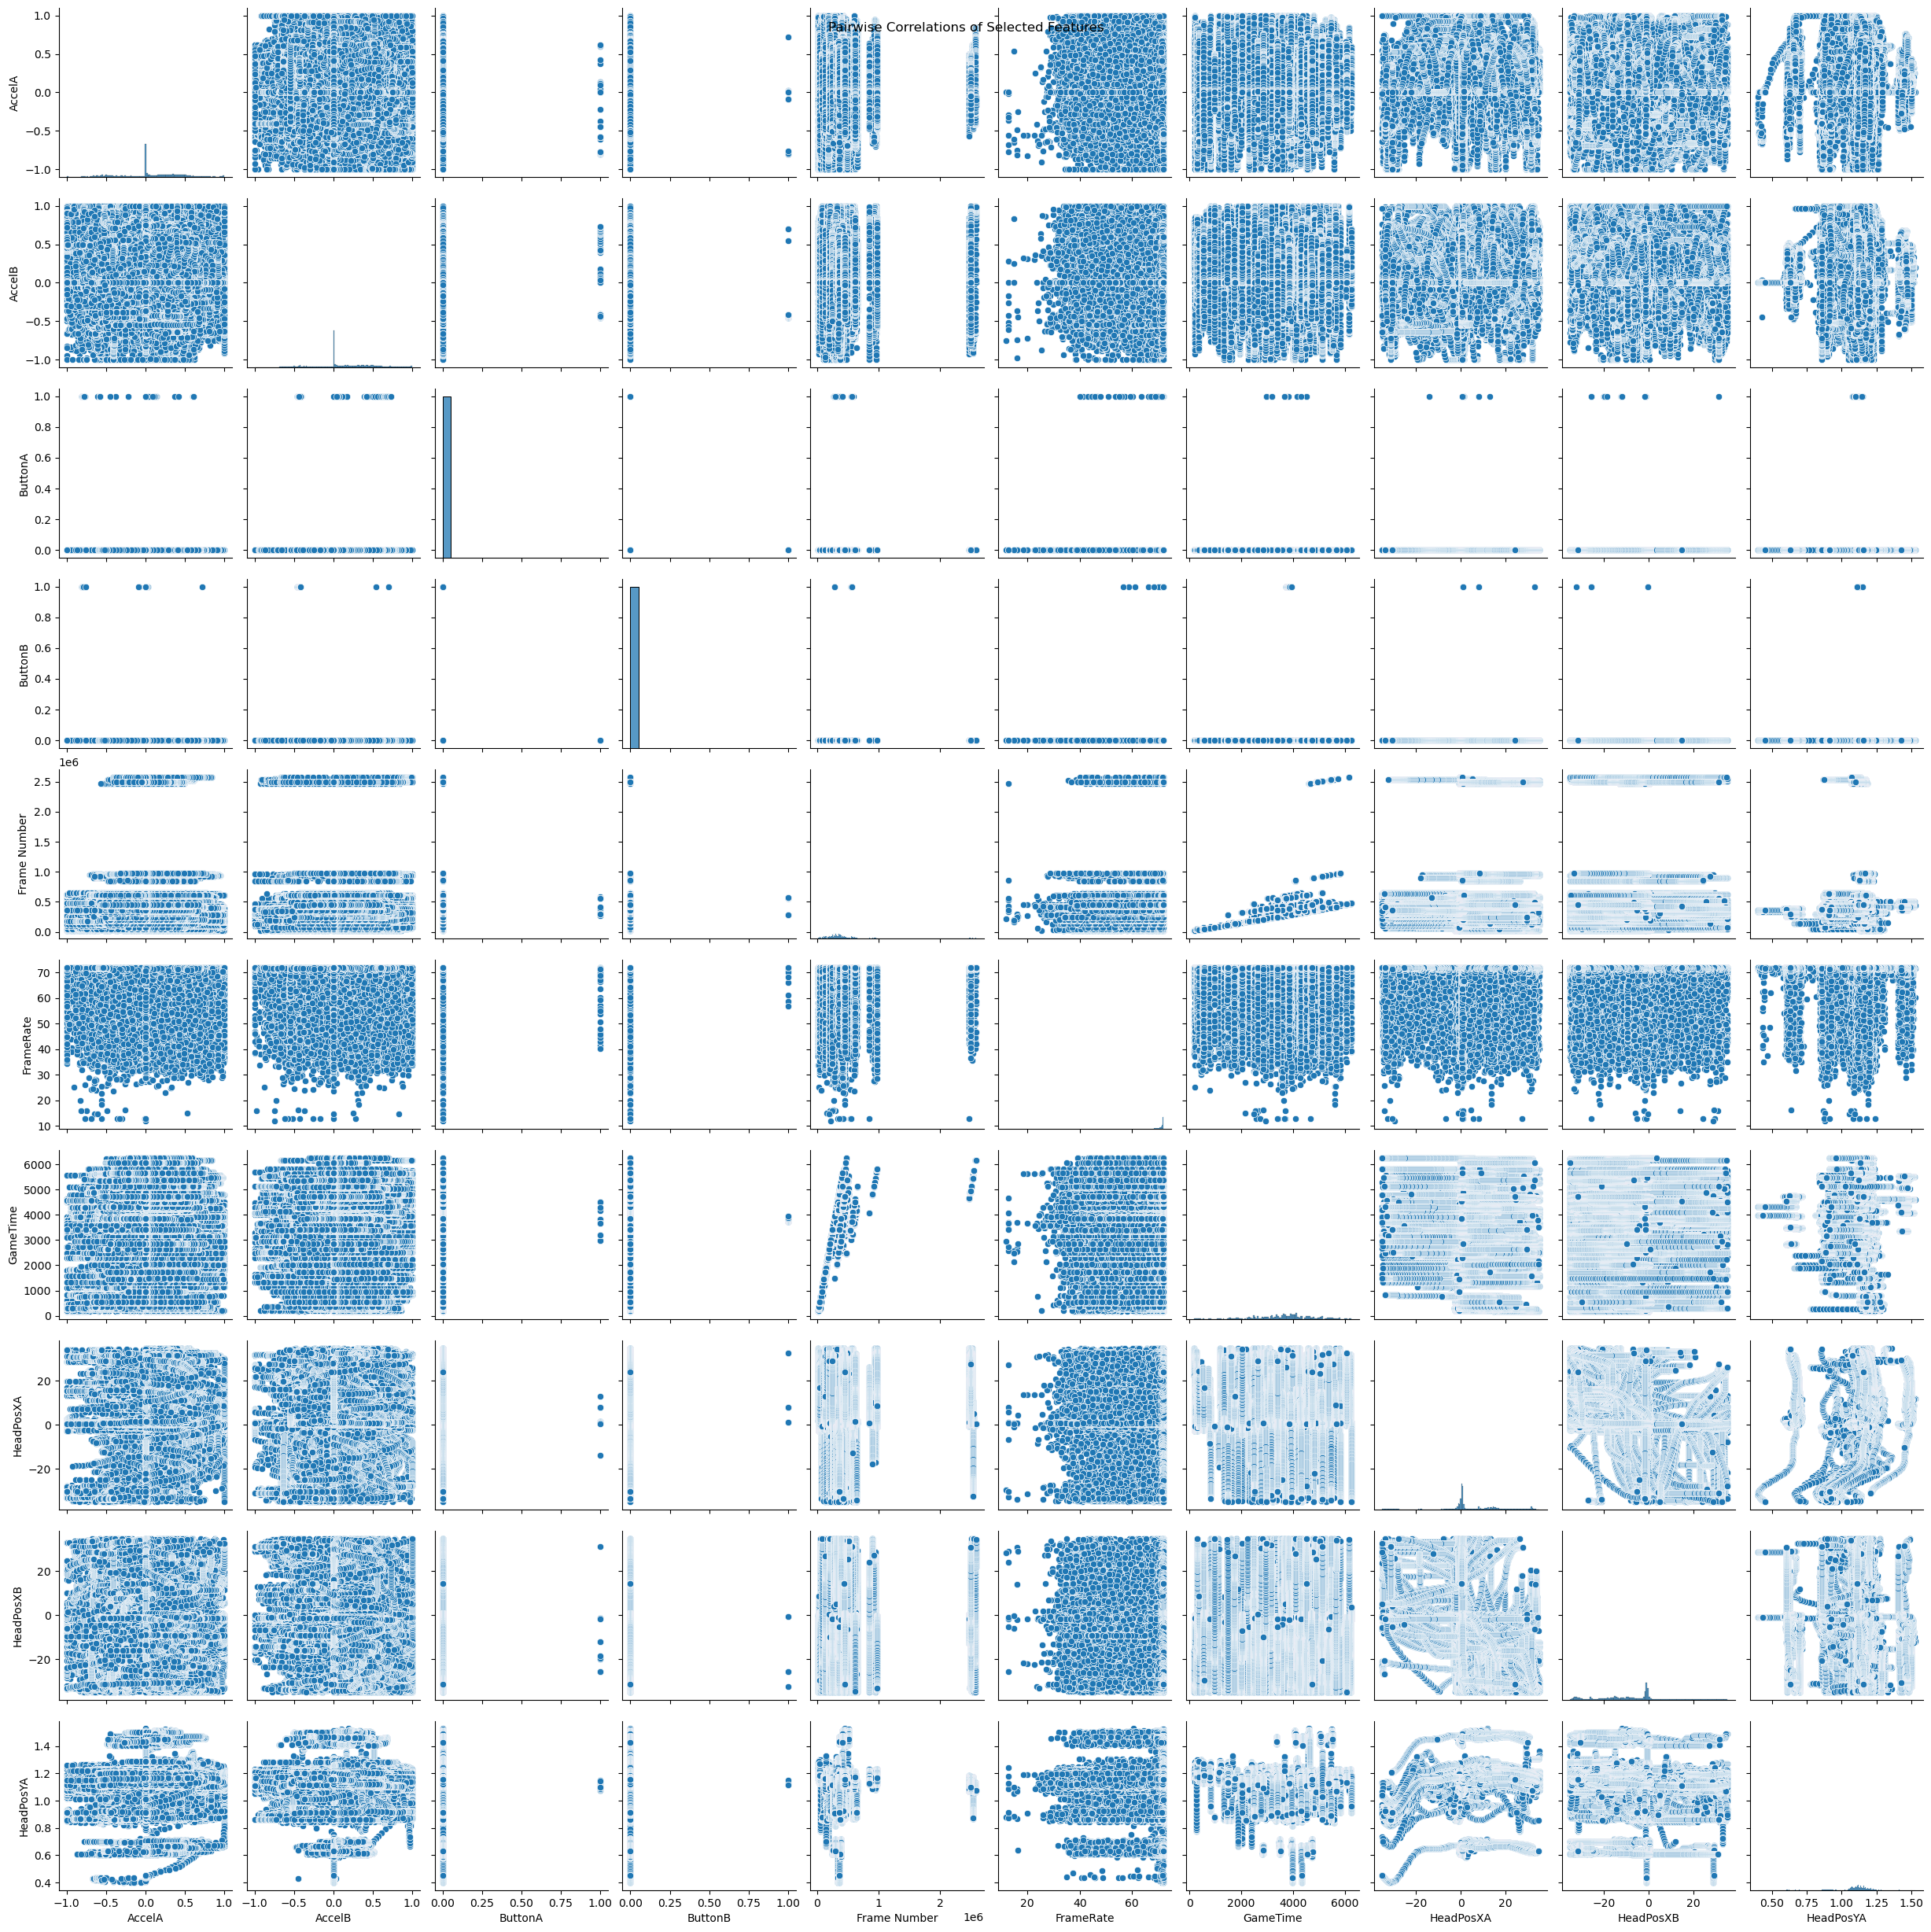

In [105]:
# Visualization 5: Pairwise Correlations of Selected Features
# Purpose: To inspect pairwise correlations and trends that could indicate relationships worth exploring further.
selected_features = filtered_data.columns[:10]  # Adjust this to include features of interest
sns.pairplot(filtered_data[selected_features])
plt.suptitle('Pairwise Correlations of Selected Features')
plt.show()

In [45]:
from sklearn.metrics import mean_absolute_error, r2_score

# Step 3: Splitting Data into Training and Test Sets
X = filtered_data.drop('AccelA', axis=1)  # Features
y = filtered_data['AccelA']  # Target variable

# Splitting the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model Training with Logging
model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)
model.fit(X_train, y_train)

# Step 6: Model Evaluation
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print metrics
print("Model Evaluation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²) score:", r2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 0.06284543448719641
Mean Absolute Error (MAE): 0.03044274873611574
R-squared (R²) score: 0.9746272000636871


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


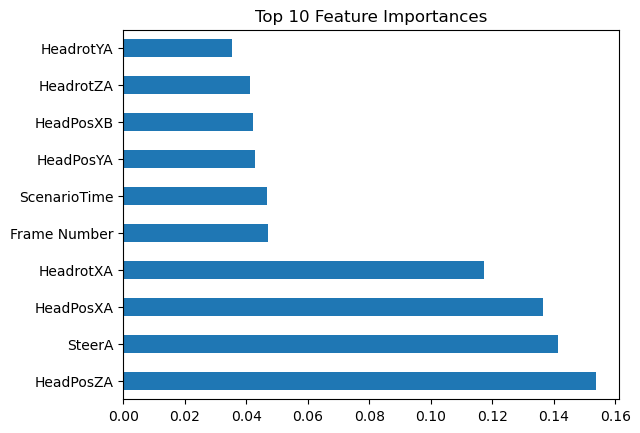

In [106]:
# Visualization 6: Feature Importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

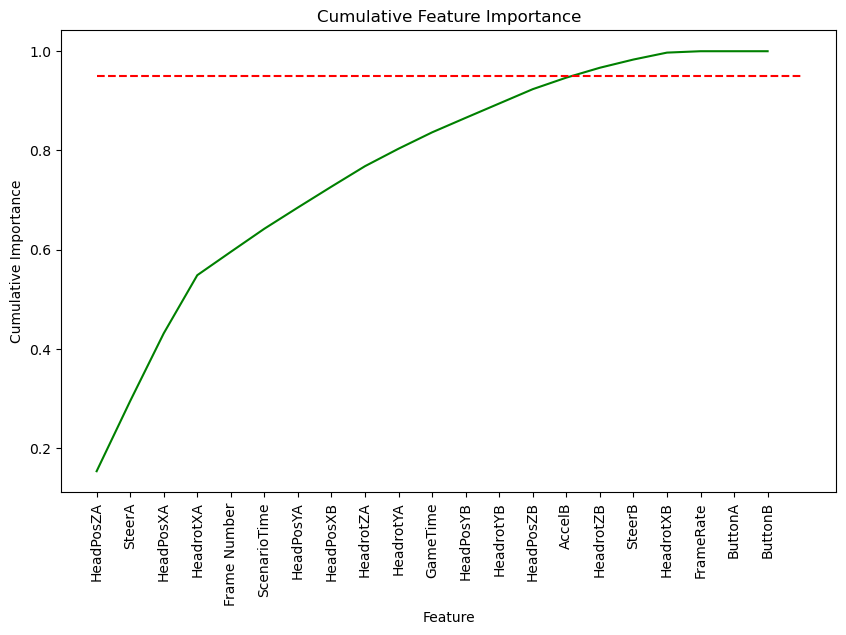

In [110]:
# Visualization 7: Cumulative Feature Importance Plot
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Cumulative Feature Importance')
cumulative_importances = np.cumsum(importances[sorted_indices])
plt.plot(cumulative_importances, 'g-')
plt.hlines(y=0.95, xmin=0, xmax=len(importances), color='r', linestyles='dashed')
plt.xticks(np.arange(len(importances)), X_train.columns[sorted_indices], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.show()

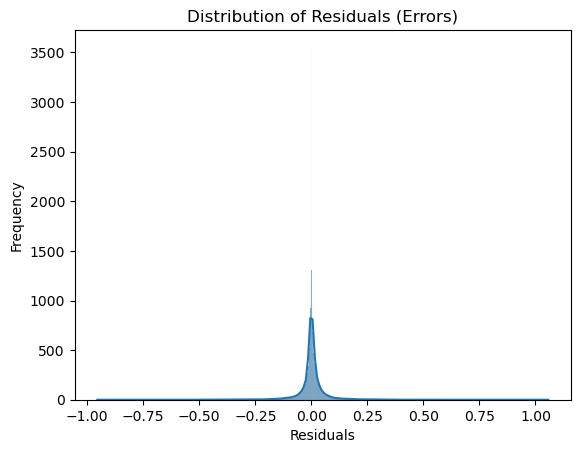

In [122]:
# Visualization 8: Residuals Plot
residuals = y_test - predictions
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Errors)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

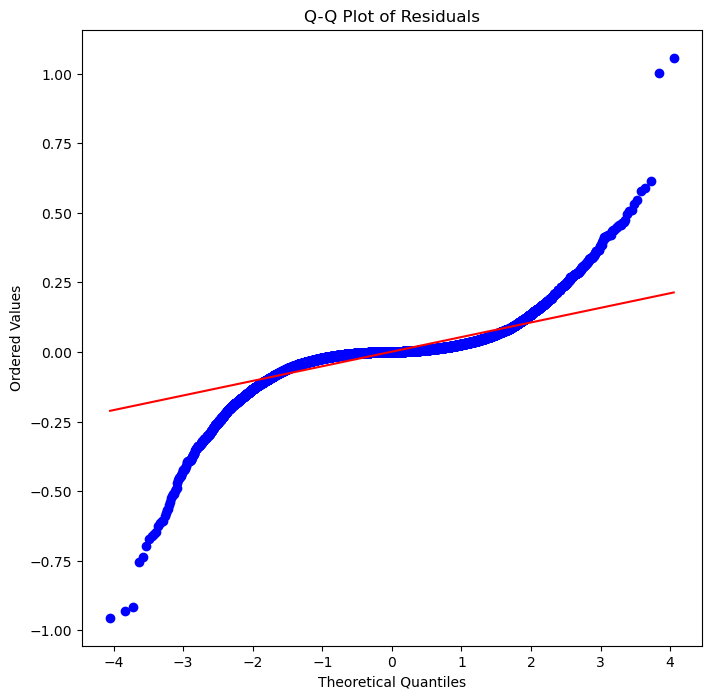

In [124]:
# Visualization 9: Q-Q Plot of Residuals
import scipy.stats as stats

plt.figure(figsize=(8, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

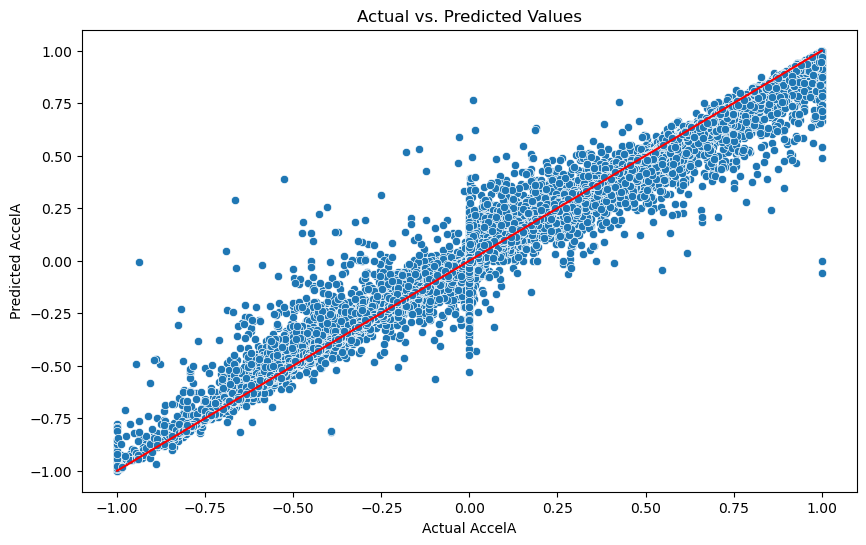

In [125]:
# Visualization 10: Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Ideal line
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual AccelA')
plt.ylabel('Predicted AccelA')
plt.show()